# `xvr` tutorial

1. Connect to a GPU: `Runtime > Change runtime type > T4 GPU`
2. Install `xvr`
3. Download data and pretrained models

In [1]:
!pip install git+https://github.com/eigenvivek/xvr.git --upgrade

  Cloning https://github.com/eigenvivek/xvr.git to c:\users\aksha\appdata\local\temp\pip-req-build-qorkvccw
  Resolved https://github.com/eigenvivek/xvr.git to commit af8287cd6d8cf0bad4cb07d746a5fff7b1eeaecb
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for xvr: filename=xvr-0.0.0rc1-py3-none-any.whl size=32494 sha256=be6dec4d551a8923a92aac86b96749dab48752e5f46a0fd0d4dbbbef3d385ee2
  Stored in directory: C:\Users\aksha\AppData\Local\Temp\pip-ephem-wheel-cache-_i3emcez\wheels\f1\a0\da\a0a1adc15d4cad93ee8225744e4588fa5e744e2620339389e9
Successfully built xvr
  Attempting uninstall: xvr
    Found existing installation: xvr 0.0.0rc1
    Uninstalling xvr-0.0.0rc1:
      Successfully uninstalled x

  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/xvr.git 'C:\Users\aksha\AppData\Local\Temp\pip-req-build-qorkvccw'

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install git+https://github.com/eigenvivek/DiffDRR.git

!pip install nibabel pydicom matplotlib tqdm


  Cloning https://github.com/eigenvivek/DiffDRR.git to c:\users\aksha\appdata\local\temp\pip-req-build-9ur1qzfj
  Resolved https://github.com/eigenvivek/DiffDRR.git to commit acaa68c9de88f50e9ac0e7adf34a68b769cf4368
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: diffdrr
    Found existing installation: diffdrr 0.5.1
    Uninstalling diffdrr-0.5.1:
      Successfully uninstalled diffdrr-0.5.1
  Running setup.py install for diffdrr: started
  Running setup.py install for diffdrr: finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/DiffDRR.git 'C:\Users\aksha\AppData\Local\Temp\pip-req-build-9ur1qzfj'
  DEPRECATION: diffdrr is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Install `xvr`

In [3]:
!xvr --version

xvr, version 0.0.0rc1


## Test-time optimization

Here, we show how to iteratively refine the initial poses estimated by a patient-specific neural network.

In [4]:
!HF_HUB_DISABLE_PROGRESS_BARS=TRUE

'HF_HUB_DISABLE_PROGRESS_BARS' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffdrr.pose import RigidTransform
from huggingface_hub import snapshot_download

from xvr.metrics import Evaluator
from xvr.registrar import RegistrarModel
from xvr.utils import XrayTransforms
from xvr.visualization import plot_registration

In [6]:
import matplotlib.pyplot as plt
import torch
from diffdrr.visualization import plot_drr
from xvr.metrics import Evaluator
from xvr.utils import XrayTransforms
from diffdrr.pose import RigidTransform

def plot_registration(drr, fiducials, gt, pred_pose, true_pose):
    """
    Visualize registration results:
    - Uses unflipped pred_pose for DRR rendering (ensures valid image)
    - Uses flipped pred_pose for fiducial projection and mTRE calculation (ensures alignment)
    """
    # Step 1: Flip a copy of the predicted pose for fiducial projection & evaluation
    flipped_pose = RigidTransform(matrix=pred_pose.matrix.clone())
    # flipped_pose.matrix[0, 0, 3] *= -1  # Flip X translation
    flipped_pose.matrix[0, 1, 3] *= -1  # Flip Y translation
    # flipped_pose.matrix[0, 2, 3] *= -1  # Flip Z translation


    # Step 2: Evaluate mTRE using pose
    evaluator = Evaluator(drr, fiducials)
    mtre = evaluator(true_pose, flipped_pose)[2]

    # Step 3: Generate DRRs and project fiducials
    with torch.no_grad():
        pred_img = drr(pred_pose).cpu()
        true_img = drr(true_pose).cpu()
        error = (true_img - pred_img)

        pred_pts = drr.perspective_projection(flipped_pose, fiducials).cpu().squeeze()
        true_pts = drr.perspective_projection(true_pose, fiducials).cpu().squeeze()

    xt = XrayTransforms(drr.detector.height, drr.detector.width)
    gt = xt(gt)
    pred_img = xt(pred_img)

    axs = plot_drr(torch.concat([pred_img, gt, error]))

    axs[1].scatter(true_pts[..., 0], true_pts[..., 1], color="dodgerblue", label="True")
    axs[1].scatter(pred_pts[..., 0], pred_pts[..., 1], color="darkorange", label="Pred")
    for x, y in zip(pred_pts, true_pts):
        axs[1].plot([x[0], y[0]], [x[1], y[1]], "w--", linewidth=0.8)
    axs[1].legend()

    plot_drr(
        torch.concat([pred_img, gt, error]),
        title=[
            "DRR from Predicted Pose",
            "Ground truth X-ray",
            f"Error (mTRE = {mtre:.2f} mm)"
        ],
        ticks=False,
        axs=axs,
    )

    axs[2].imshow(
        error[0].permute(1, 2, 0),
        cmap="bwr",
        vmin=-error.abs().max(),
        vmax=error.abs().max()
    )

    plt.tight_layout()
    plt.show()


## Evaluating pretrained models

Here, we are using the pretrained models and testing them using our Femur CT data and x ray image to find the pose value.

In [7]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Model Evaluation

In [128]:
true_pose = torch.load("Results/980x980/xray_pose.pt", weights_only=False).cuda()

print("True Pose:",true_pose.matrix)

True Pose: tensor([[[  1.,   0.,   0.,   0.],
         [  0.,   1.,   0., 850.],
         [  0.,   0.,   1., 150.],
         [  0.,   0.,   0.,   1.]]], device='cuda:0')


In [129]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    """
    Converts a 4x4 homogeneous pose matrix to Euler angles and translation vector.

    Args:
        pose_matrix (torch.Tensor): shape [4, 4] or [1, 4, 4]
        convention (str): e.g., "ZXY"
        degrees (bool): Return angles in degrees (True) or radians (False)

    Returns:
        euler_angles (torch.Tensor): shape [3] (rx, ry, rz)
        translation (torch.Tensor): shape [3] (x, y, z)
    """
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(true_pose.matrix, convention="ZXY", degrees=True)
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Rotation angles (ZXY) in degrees: tensor([0., 0., 0.])
Translation (mm): tensor([  0., 850., 150.])


In [130]:
# Load the ground truth 3D fiducials
fiducials = torch.load("Results/980x980/xray_fiducials.pt", weights_only=False).cuda()
# fiducials = fiducials.unsqueeze(0)  # Adds a batch dimension at dim=0

In [131]:
print("Fiducials",fiducials)

Fiducials tensor([[[-4.3840e+01, -1.5000e+02,  9.8949e+01],
         [-4.6752e+01, -1.5000e+02,  1.0935e+02],
         [-3.7183e+01, -1.5000e+02,  1.2557e+02],
         [-3.0111e+01, -1.5000e+02,  8.8549e+01],
         [-5.9823e+00, -1.5000e+02,  9.8949e+01],
         [-2.7199e+01, -1.5000e+02,  1.0769e+02],
         [-1.1390e+01, -1.5000e+02,  1.2225e+02],
         [-1.8463e+01, -1.5000e+02,  1.3181e+02],
         [-3.0701e+00, -1.5000e+02,  1.0893e+02],
         [ 2.2307e+01, -1.5000e+02,  1.0602e+02],
         [ 1.1490e+01, -1.5000e+02,  1.1226e+02],
         [ 1.0658e+01, -1.5000e+02,  1.1725e+02],
         [ 9.4103e+00, -1.5000e+02,  1.1975e+02],
         [-1.8047e+01, -1.5000e+02,  1.5927e+02],
         [ 3.1459e+01, -1.5000e+02,  1.3473e+02],
         [ 2.6883e+01, -1.5000e+02,  1.1725e+02],
         [-2.6541e+00, -1.5000e+02,  1.4055e+02],
         [ 3.5861e+00, -1.5000e+02,  1.6302e+02],
         [ 2.3380e+00, -1.5000e+02,  1.9380e+02],
         [ 2.3380e+00, -1.5000e+02,  2.2

Dataset.file_meta -------------------------------
(0002,0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.50568109045326789714718063247338005418
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.50568109045326789714718063247338005418
(0008,0020) Study Date                          DA: '20250725'
(0008,0030) Study Time                          TM: '124539'
(0008,0060) Modality                            CS: 'OT'
(0010,0010) Patient's Name                      PN: 'Synthetic'
(0010,0020) Patient ID   

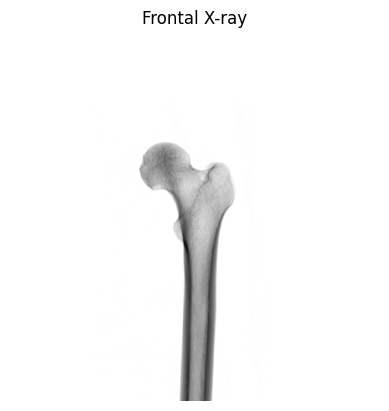

In [132]:
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

dicom_img = pydicom.dcmread("Results/980x980/xray_image.dcm")

# Print metadata
print(dicom_img)

# Display the image
plt.imshow(dicom_img.pixel_array, cmap='gray')
plt.title("Frontal X-ray")
plt.axis('off')
plt.show()


In [133]:
model_agnostic = RegistrarModel(
        volume="SE000002.nii",
        mask=None,
        # ckptpath="trained-new-paths/finetuned02_10ep.pth",
        # ckptpath = "/content/drive/MyDrive/Trained Registration model/Finetuned/Agnostic Fine tuned Default Parameter/xvr_0005.pth", # Best for full bone
        ckptpath = "output_finetuned/RXVR1.1_Finetuned_0008.pth",
        crop=0,
        init_only=False,
    )

In [119]:
# import pydicom

# # Load your C-arm DICOM file
# filename = "C_Arm/1.2.840.113780.9800.8251012.20250716145723.3.40.dcm"  # Update this path if needed
# ds = pydicom.dcmread(filename)

# # Set the missing attribute
# ds.DistanceSourceToDetector = 1000  # Replace 1000 with your actual sdd value in mm

# # Optional: make sure PixelSpacing is present and valid
# if "PixelSpacing" not in ds:
#     ds.PixelSpacing = [0.316, 0.316]  # based on your delx

# # Save the updated DICOM
# ds.save_as(filename)
# print("DICOM updated with SDD and saved.")


DICOM updated with SDD and saved.


In [134]:
# print(ds.DistanceSourceToDetector)
# print(ds.PixelSpacing)


In [135]:
# Demonstrate the patient-agnostic model
gt, _, drr, init_pose, final_pose, _ = model_agnostic.run("Results/980x980/xray_image.dcm", beta=0.5)


Stage 1:   9%|███▌                                    | 44/500 [00:00<00:08, 51.90it/s, ncc = 0.279]


In [136]:
print("Initial Pose:",init_pose.matrix)
print(type(init_pose))

Initial Pose: tensor([[[ 7.3950e-01,  6.3463e-01,  2.2444e-01, -3.9872e+02],
         [-6.6966e-01,  7.2747e-01,  1.4945e-01, -4.7473e+02],
         [-6.8429e-02, -2.6082e-01,  9.6296e-01,  3.0612e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
<class 'diffdrr.pose.RigidTransform'>


In [137]:
print("Final Pose:",final_pose.matrix)
print(type(final_pose))

Final Pose: tensor([[[ 7.3365e-01,  6.4288e-01,  2.2015e-01, -4.1756e+02],
         [-6.7582e-01,  7.2411e-01,  1.3761e-01, -4.8952e+02],
         [-7.0944e-02, -2.4973e-01,  9.6571e-01,  3.0417e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<CopySlices>)
<class 'diffdrr.pose.RigidTransform'>


In [138]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(init_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Initial Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Initial Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([-42.6307,  -8.5951,  13.1200])
Translation (mm): tensor([-398.7206, -474.7302,  306.1176])


In [139]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(final_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Final Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Final Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([-43.0242,  -7.9095,  12.8418])
Translation (mm): tensor([-417.5594, -489.5211,  304.1693])


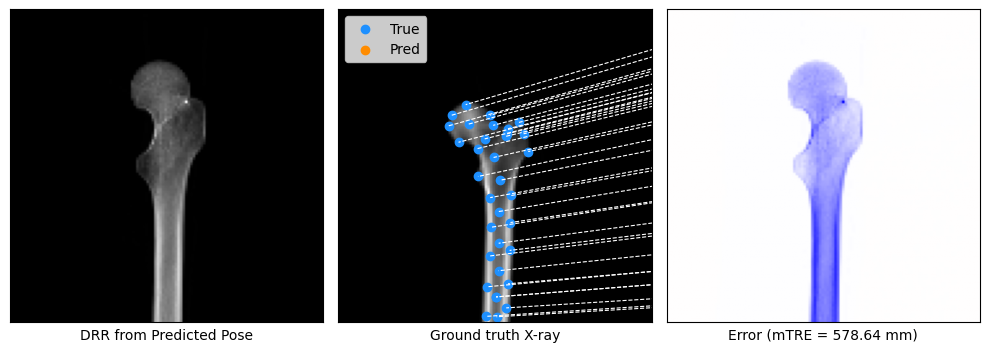

In [140]:
plot_registration(drr, fiducials, gt, init_pose, true_pose)

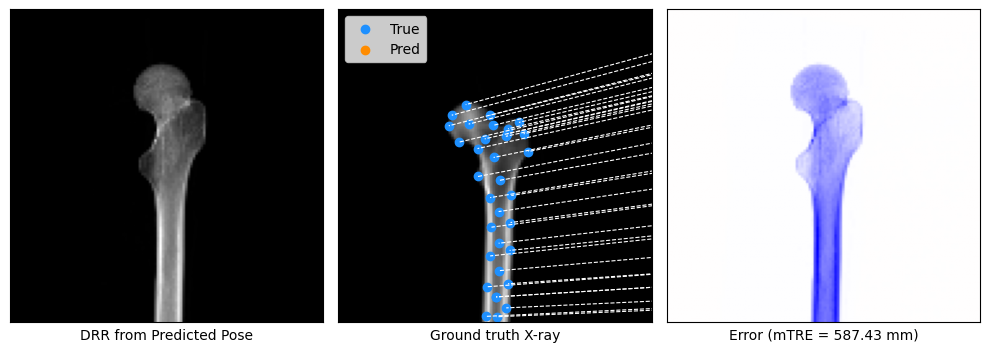

In [141]:
plot_registration(drr, fiducials, gt, final_pose, true_pose)